# **Csomagok behívása**

In [1]:
#Szükséges csomagok és adatbázis importálása
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input, Concatenate
import numpy as np
import tensorflow as tf
import spacy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Fájlok behívása, ellenőrzése és felkészítése

In [2]:
# Betölteni padded sequences, tokenizer, és számokat
padded_train = np.load('/content/padded_train04.npy')
padded_test = np.load('/content/padded_test04.npy')

# Tokenizer visszatöltése
with open('/content/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Címkék betöltése (real = 1, fake = 0)
train_file = '/content/train_negyedik.csv'
test_file = '/content/teszt_negyedik.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

labels_train = df_train['label'].values
labels_test = df_test['label'].values

# Betölteni embedding mátrixot
embedding_matrix = np.load('/content/embedding_matrix.npy')

# Ellenőrzés
print(f"Train padded sequences shape: {padded_train.shape}")
print(f"Test padded sequences shape: {padded_test.shape}")
print(f"Train labels shape: {labels_train.shape}")
print(f"Test labels shape: {labels_test.shape}")

Train padded sequences shape: (59520, 600)
Test padded sequences shape: (14880, 600)
Train labels shape: (59520,)
Test labels shape: (14880,)


In [3]:
# Max szókincs és szekvencia hossz
MAX_VOCAB_SIZE = 25000
MAX_LENGTH = 600
EMBEDDING_DIM = 300  # GloVe 300d

# input shape
MAX_SEQUENCE_LENGTH = padded_train.shape[1]

# Szöveges input (LSTM/GRU bemenet)
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
embedding_layer = Embedding(
    input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)(text_input)

model_output = embedding_layer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [4]:
MAX_SEQUENCE_LENGTH = padded_train.shape[1]  # Train hossz
EMBEDDING_DIM = embedding_matrix.shape[1]  # GloVe embeddings

# 10%-os validációs halmaz leválasztása a tanító adatokból
padded_train_final, padded_val, y_train_final, y_val = train_test_split(
    padded_train, labels_train, test_size=0.1, random_state=42
)
# Float32-re konvertálás TensorFlow kompatibilitás miatt
padded_train_final = np.array(padded_train_final, dtype=np.float32)
padded_val = np.array(padded_val, dtype=np.float32)
padded_test = np.array(padded_test, dtype=np.float32)
y_train_final = np.array(y_train_final, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(labels_test, dtype=np.float32)

# Korai leállítás beállítása
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# LSTM MODELL 3. ELŐFELDOLGOZÁSNÁL


## Modell lefuttatása

In [5]:
# LSTM modell, trainable, non-trainable embedding

def create_lstm_model(trainable_embeddings=True):
    # Szöveges input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
    text_embedding = Embedding(
        input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=trainable_embeddings
    )(text_input)

    # LSTM rétegek
    lstm_out = LSTM(128, return_sequences=True, dropout=0.3)(text_embedding)
    lstm_out = Dropout(0.3)(lstm_out)  # Dropout réteg az első LSTM után
    lstm_out = LSTM(64,return_sequences=True, dropout=0.3)(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out) # Dropout réteg az második LSTM után
    lstm_out = LSTM(32, dropout=0.3)(lstm_out)

    # Kimeneti réteg
    output = Dense(1, activation='sigmoid')(lstm_out)  # Binary classification

    # Modell létrehozása
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Modell létrehozása
lstm_trainable = create_lstm_model(trainable_embeddings=True)  # Trainable embedding

lstm_trainable.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 600, 300)            │       7,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 600, 128)            │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 600, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 600, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 600, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,781,505 (29.68 MB)

 Trainable params: 7,781,505 (29.68 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Modell tanítása a validációs adatok figyelésével
lstm_history_trainable = lstm_trainable.fit(
    padded_train_final, y_train_final,
    validation_data=(padded_val, y_val),  # Validációs halmaz
    epochs=10, batch_size=64, callbacks=[early_stopping]
)

# Végső tesztelés a teljesen független teszthalmazon
test_loss, test_accuracy = lstm_trainable.evaluate(padded_test, y_test)
print(f"Teszthalmaz pontosság: {test_accuracy:.4f}, Teszthalmaz veszteség: {test_loss:.4f}")


Epoch 1/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 77s 83ms/step - accuracy: 0.8242 - loss: 0.4065 - val_accuracy: 0.8987 - val_loss: 0.2609
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 79s 85ms/step - accuracy: 0.9175 - loss: 0.2274 - val_accuracy: 0.9346 - val_loss: 0.1885
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.9450 - loss: 0.1556 - val_accuracy: 0.9157 - val_loss: 0.2424
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9376 - loss: 0.1800 - val_accuracy: 0.9477 - val_loss: 0.1487
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9695 - loss: 0.0923 - val_accuracy: 0.9639 - val_loss: 0.1107
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9844 - loss: 0.0515 - val_accuracy: 0.9689 - val_loss: 0.1122
Epoch 7/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.9911 - loss: 0.0318 - val_accuracy: 0.9699 - val_loss: 0.1013
Epoch 8/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9944 - loss: 0.0224 - 

In [7]:
# Valószínűség becslése
lstm_y_prob = lstm_trainable.predict(padded_test)

lstm_y_pred = (lstm_y_prob > 0.5).astype(int)

lstm_accuracy = accuracy_score(y_test, lstm_y_pred)
lstm_precision = precision_score(y_test, lstm_y_pred)
lstm_recall = recall_score(y_test, lstm_y_pred)
lstm_f1 = f1_score(y_test, lstm_y_pred)

print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall: {lstm_recall:.4f}")
print(f"F1-score: {lstm_f1:.4f}")


465/465 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step
Accuracy: 0.9635
Precision: 0.9656
Recall: 0.9613
F1-score: 0.9634


## LSTM Modell ábrák

465/465 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9665 - loss: 0.1097


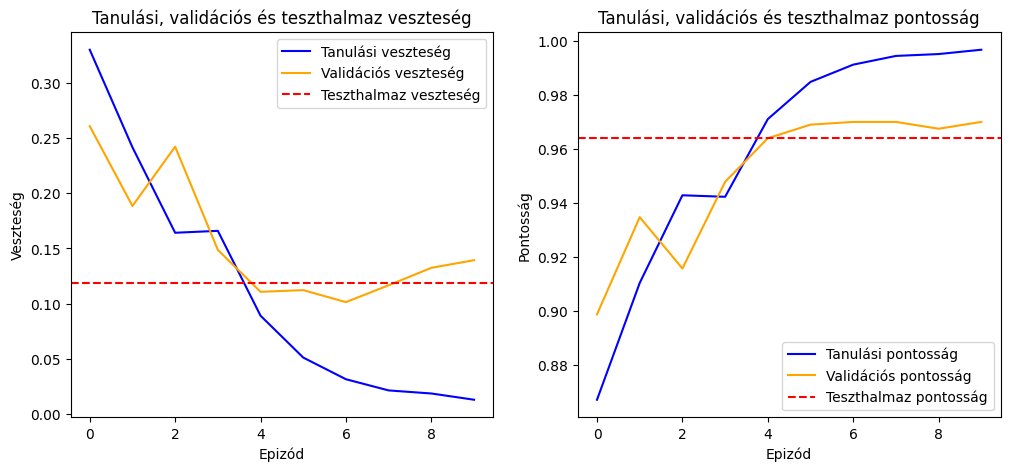

In [8]:
import matplotlib.pyplot as plt

# Modell tesztelése a független teszthalmazon
test_loss, test_accuracy = lstm_trainable.evaluate(padded_test, y_test)

# Plot tanulási, validációs és teszt veszteség
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history_trainable.history['loss'], label='Tanulási veszteség', color='blue')
plt.plot(lstm_history_trainable.history['val_loss'], label='Validációs veszteség', color='orange')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Teszthalmaz veszteség')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Veszteség')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz veszteség')

# Plot tanulási, validációs és teszt pontosság
plt.subplot(1, 2, 2)
plt.plot(lstm_history_trainable.history['accuracy'], label='Tanulási pontosság', color='blue')
plt.plot(lstm_history_trainable.history['val_accuracy'], label='Validációs pontosság', color='orange')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Teszthalmaz pontosság')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Pontosság')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz pontosság')

plt.show()


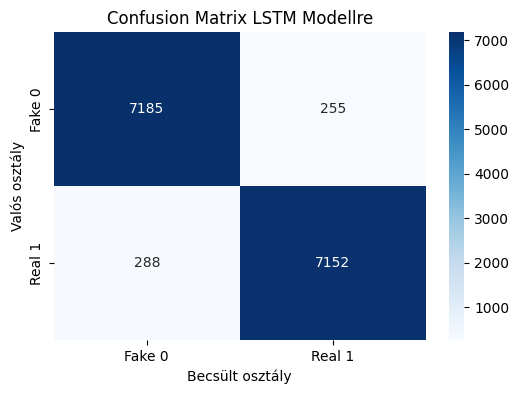

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      7440
         1.0       0.97      0.96      0.96      7440

    accuracy                           0.96     14880
   macro avg       0.96      0.96      0.96     14880
weighted avg       0.96      0.96      0.96     14880



In [9]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, lstm_y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake 0", "Real 1"], yticklabels=["Fake 0", "Real 1"])
plt.xlabel('Becsült osztály')
plt.ylabel('Valós osztály')
plt.title('Confusion Matrix LSTM Modellre')
plt.show()

print(classification_report(y_test, lstm_y_pred))


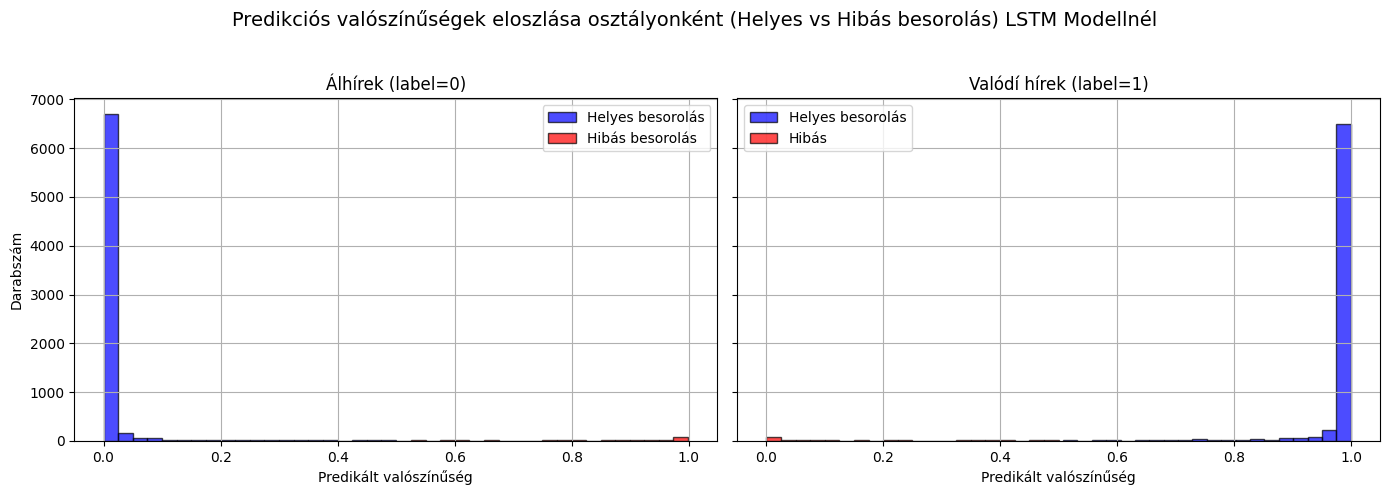

In [10]:
# Flatten
y_true = y_test.flatten()
y_pred = lstm_y_pred.flatten()
y_prob = lstm_y_prob.flatten()

# Valódi hírek (label=1)
true_real_indices = np.where(y_true == 1)[0]
correct_real = y_prob[(y_true == 0) & (y_pred == 0)]
incorrect_real = y_prob[(y_true == 0) & (y_pred != 0)]

# Álhírek (label=0)
true_fake_indices = np.where(y_true == 0)[0]
correct_fake = y_prob[(y_true == 1) & (y_pred == 1)]
incorrect_fake = y_prob[(y_true == 1) & (y_pred != 1)]

# Plot - két hisztogram egymás mellett
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Álhírek (label = 0)
axes[0].hist(correct_real, bins=20, alpha=0.7, label="Helyes besorolás", color="blue", edgecolor="black")
axes[0].hist(incorrect_real, bins=20, alpha=0.7, label="Hibás besorolás", color="red", edgecolor="black")
axes[0].set_title("Álhírek (label=0)")
axes[0].set_xlabel("Predikált valószínűség")
axes[0].set_ylabel("Darabszám")
axes[0].legend()
axes[0].grid(True)

# Valódi hírek (label = 1)
axes[1].hist(correct_fake, bins=20, alpha=0.7, label="Helyes besorolás", color="blue", edgecolor="black")
axes[1].hist(incorrect_fake, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[1].set_title("Valódí hírek (label=1)")
axes[1].set_xlabel("Predikált valószínűség")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Predikciós valószínűségek eloszlása osztályonként (Helyes vs Hibás besorolás) LSTM Modellnél", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [11]:
# DataFrame a valódi és predikált címkékkel
df_results = pd.DataFrame({
    "Valódi címke": y_test.flatten(),
    "Prediktált címke": lstm_y_pred.flatten()
})

# Félrebesorolt példák kiszűrése
df_misclassified = df_results[df_results["Valódi címke"] != df_results["Prediktált címke"]].copy()
misclassified_indices = df_misclassified.index

# Tokenizált bemenetek kiválasztása a félrebesorolt példákhoz
misclassified_sequences = padded_test[misclassified_indices]

# Tokenek visszaalakítása szöveggé
misclassified_texts = tokenizer.sequences_to_texts(misclassified_sequences)

# <OOV> kiszűrése a szövegekből
misclassified_texts_cleaned = []
for text in misclassified_texts:
    cleaned_text = " ".join([word for word in text.split() if word.lower().strip() not in ["<oov>", "oov", "[oov]", "(oov)"]])
    misclassified_texts_cleaned.append(cleaned_text)

# Szöveg hozzáadása a táblázathoz
df_misclassified["Szöveg"] = misclassified_texts_cleaned

# Hibatípus meghatározása (FP vagy FN)
df_misclassified.insert(0, "Hiba típusa", df_misclassified.apply(
    lambda row: "Hamis pozitív (FP)" if row["Valódi címke"] == 0 else "Hamis negatív (FN)", axis=1))

# Valószínűségek hozzáadása
misclassified_probs = lstm_y_prob[misclassified_indices].flatten()
df_misclassified["Predikció valószínűsége"] = np.round(misclassified_probs, 4)

# Fájl mentése
file_path = "/content/felrebesorolt_peldak_clean_lstm.csv"
df_misclassified.to_csv(file_path, index=False, encoding="utf-8")

# Táblázat megjelenítése
pd.set_option("display.max_colwidth", None)
display(df_misclassified.head(20))


Hiba típusa  Valódi címke  Prediktált címke  \
30   Hamis pozitív (FP)           0.0                 1   
41   Hamis negatív (FN)           1.0                 0   
134  Hamis negatív (FN)           1.0                 0   
151  Hamis pozitív (FP)           0.0                 1   
168  Hamis negatív (FN)           1.0                 0   
235  Hamis pozitív (FP)           0.0                 1   
244  Hamis negatív (FN)           1.0                 0   
259  Hamis pozitív (FP)           0.0                 1   
275  Hamis negatív (FN)           1.0                 0   
293  Hamis pozitív (FP)           0.0                 1   
356  Hamis negatív (FN)           1.0                 0   
362  Hamis pozitív (FP)           0.0                 1   
391  Hamis pozitív (FP)           0.0                 1   
408  Hamis negatív (FN)           1.0                 0   
443  Hamis pozitív (FP)           0.0                 1   
568  Hamis pozitív (FP)           0.0                 1   
570  Hamis pozitív (FP)           0.0                 1   
576  Hamis pozitív (FP)           0.0                 1   
579  Hamis negatív (FN)           1.0                 0   
590  Hamis pozitív (FP)           0.0                 1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# GRU MODELL 3. ELŐFELDOLGOZÁSNÁL


### Modell lefuttatása

In [12]:
# GRU modell

def create_gru_model(trainable_embeddings=True):
    # Szöveges input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
    text_embedding = Embedding(
        input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),  # Ensure within vocab limit
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=trainable_embeddings  # Toggle trainability
    )(text_input)

    # GRU rétegek
    gru_out = GRU(128, return_sequences=True, dropout=0.3)(text_embedding)
    gru_out = Dropout(0.3)(gru_out)  # Dropout réteg az első GRU után
    gru_out = GRU(64,return_sequences=True, dropout=0.3)(gru_out)
    gru_out = Dropout(0.3)(gru_out)
    gru_out = GRU(32, dropout=0.3)(gru_out)

    # Kimeneti réteg
    output = Dense(1, activation='sigmoid')(gru_out)  # Binary classification

    # Modell létrehozása
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Modell létrehozása (Trainable)
gru_trainable = create_gru_model(trainable_embeddings=True)  # Trainable

gru_trainable.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 600, 300)            │       7,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 600, 128)            │         165,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 600, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 600, 64)             │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 600, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,711,809 (29.42 MB)

 Trainable params: 7,711,809 (29.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Korai leállítás beállítása
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# GRU modell tanítása a validációs adatok figyelésével
history_gru_trainable = gru_trainable.fit(
    padded_train_final, y_train_final,  # Ugyanaz a tanító adathalmaz, mint az LSTM-nél
    validation_data=(padded_val, y_val),  # Ugyanaz a validációs halmaz, mint az LSTM-nél
    epochs=10, batch_size=64, callbacks=[early_stopping]
)

# Végső tesztelés a teljesen független teszthalmazon
test_loss_gru, test_accuracy_gru = gru_trainable.evaluate(padded_test, y_test)
print(f"Teszthalmaz pontosság (GRU): {test_accuracy_gru:.4f}, Teszthalmaz veszteség (GRU): {test_loss_gru:.4f}")

Epoch 1/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.8473 - loss: 0.3479 - val_accuracy: 0.9420 - val_loss: 0.1580
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.9588 - loss: 0.1136 - val_accuracy: 0.9711 - val_loss: 0.0831
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.9860 - loss: 0.0421 - val_accuracy: 0.9738 - val_loss: 0.0801
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 79s 78ms/step - accuracy: 0.9921 - loss: 0.0244 - val_accuracy: 0.9761 - val_loss: 0.0847
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9953 - loss: 0.0160 - val_accuracy: 0.9758 - val_loss: 0.0976
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.9960 - loss: 0.0123 - val_accuracy: 0.9718 - val_loss: 0.1158
465/465 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9737 - loss: 0.0825
Teszthalmaz pontosság (GRU): 0.9720, Teszthalmaz veszteség (GRU): 0.0879


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Valószínűség becslése
gru_y_prob = gru_trainable.predict(padded_test)

gru_y_pred = (gru_y_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, gru_y_pred)
precision = precision_score(y_test, gru_y_pred)
recall = recall_score(y_test, gru_y_pred)
f1 = f1_score(y_test, gru_y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


465/465 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Accuracy: 0.9718
Precision: 0.9811
Recall: 0.9621
F1-score: 0.9715


## GRU modell ábrák

465/465 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9739 - loss: 0.0827


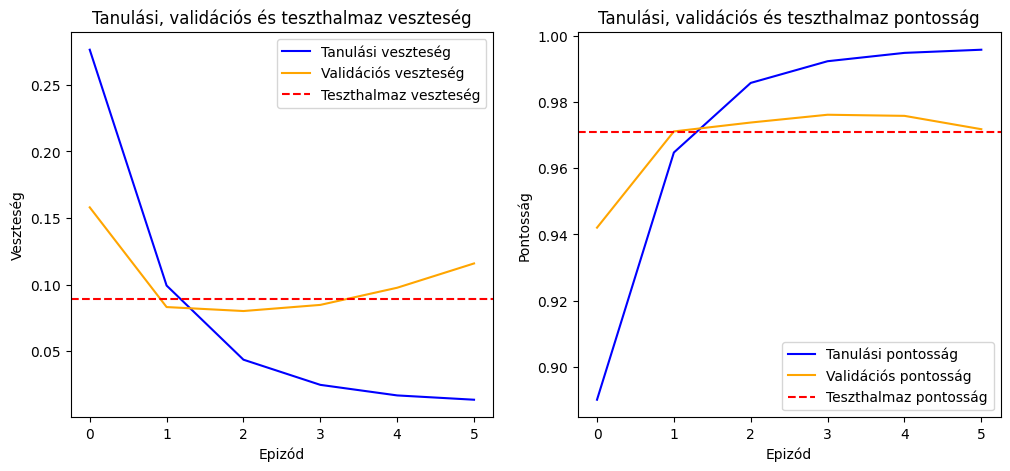

In [15]:
# Modell tesztelése a független teszthalmazon
test_loss, test_accuracy = gru_trainable.evaluate(padded_test, y_test)

# Plot tanulási, validációs és teszt veszteség
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru_trainable.history['loss'], label='Tanulási veszteség', color='blue')
plt.plot(history_gru_trainable.history['val_loss'], label='Validációs veszteség', color='orange')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Teszthalmaz veszteség')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Veszteség')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz veszteség')

# Plot tanulási, validációs és teszt pontosság
plt.subplot(1, 2, 2)
plt.plot(history_gru_trainable.history['accuracy'], label='Tanulási pontosság', color='blue')
plt.plot(history_gru_trainable.history['val_accuracy'], label='Validációs pontosság', color='orange')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Teszthalmaz pontosság')  # Teszthalmaz hozzáadása
plt.xlabel('Epizód')
plt.ylabel('Pontosság')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz pontosság')

plt.show()


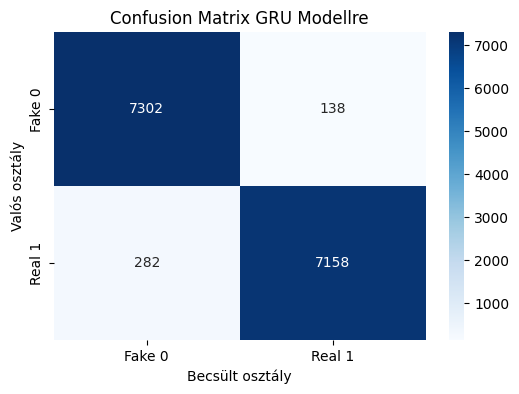

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      7440
         1.0       0.98      0.96      0.97      7440

    accuracy                           0.97     14880
   macro avg       0.97      0.97      0.97     14880
weighted avg       0.97      0.97      0.97     14880



In [16]:
# Confusion Matrix
cm_gru = confusion_matrix(y_test, gru_y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake 0", "Real 1"], yticklabels=["Fake 0", "Real 1"])
plt.xlabel('Becsült osztály')
plt.ylabel('Valós osztály')
plt.title('Confusion Matrix GRU Modellre')
plt.show()

print(classification_report(y_test, gru_y_pred))

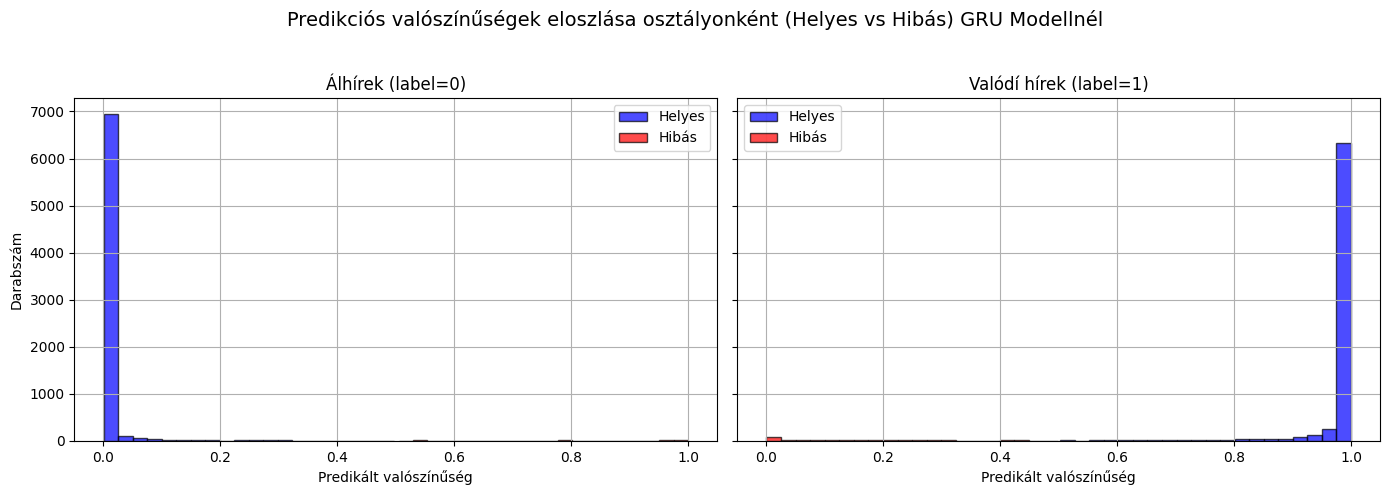

In [17]:
# Flatten
y_true = y_test.flatten()
y_pred = gru_y_pred.flatten()
y_prob = gru_y_prob.flatten()

# Valódi hírek (label=1)
true_real_indices = np.where(y_true == 1)[0]
correct_real = y_prob[(y_true == 0) & (y_pred == 0)]
incorrect_real = y_prob[(y_true == 0) & (y_pred != 0)]

# Álhírek (label=0)
true_fake_indices = np.where(y_true == 0)[0]
correct_fake = y_prob[(y_true == 1) & (y_pred == 1)]
incorrect_fake = y_prob[(y_true == 1) & (y_pred != 1)]

# Plot - két hisztogram egymás mellett
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Álhírek (label = 0)
axes[0].hist(correct_real, bins=20, alpha=0.7, label="Helyes", color="blue", edgecolor="black")
axes[0].hist(incorrect_real, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[0].set_title("Álhírek (label=0)")
axes[0].set_xlabel("Predikált valószínűség")
axes[0].set_ylabel("Darabszám")
axes[0].legend()
axes[0].grid(True)

# Valódi hírek (label = 1)
axes[1].hist(correct_fake, bins=20, alpha=0.7, label="Helyes", color="blue", edgecolor="black")
axes[1].hist(incorrect_fake, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[1].set_title("Valódí hírek (label=1)")
axes[1].set_xlabel("Predikált valószínűség")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Predikciós valószínűségek eloszlása osztályonként (Helyes vs Hibás) GRU Modellnél", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
# DataFrame a valódi és predikált címkékkel
df_results = pd.DataFrame({
    "Valódi címke": y_test.flatten(),
    "Prediktált címke": gru_y_pred.flatten()
})

# Félrebesorolt példák kiszűrése
df_misclassified = df_results[df_results["Valódi címke"] != df_results["Prediktált címke"]].copy()
misclassified_indices = df_misclassified.index

# Tokenizált bemenetek kiválasztása a félrebesorolt példákhoz
misclassified_sequences = padded_test[misclassified_indices]

# Tokenek visszaalakítása szöveggé
misclassified_texts = tokenizer.sequences_to_texts(misclassified_sequences)

# <OOV> kiszűrése a szövegekből
misclassified_texts_cleaned = []
for text in misclassified_texts:
    cleaned_text = " ".join([word for word in text.split() if word.lower().strip() not in ["<oov>", "oov", "[oov]", "(oov)"]])
    misclassified_texts_cleaned.append(cleaned_text)

# Szöveg hozzáadása a táblázathoz
df_misclassified["Szöveg"] = misclassified_texts_cleaned

# Hibatípus meghatározása (FP vagy FN)
df_misclassified.insert(0, "Hiba típusa", df_misclassified.apply(
    lambda row: "Hamis pozitív (FP)" if row["Valódi címke"] == 0 else "Hamis negatív (FN)", axis=1))

# Valószínűségek hozzáadása
misclassified_probs = gru_y_prob[misclassified_indices].flatten()
df_misclassified["Predikció valószínűsége"] = np.round(misclassified_probs, 4)

# Fájl mentése
file_path = "/content/felrebesorolt_peldak_clean_gru.csv"
df_misclassified.to_csv(file_path, index=False, encoding="utf-8")

# Táblázat megjelenítése
pd.set_option("display.max_colwidth", None)
display(df_misclassified.head(20))


Hiba típusa  Valódi címke  Prediktált címke  \
41    Hamis negatív (FN)           1.0                 0   
275   Hamis negatív (FN)           1.0                 0   
293   Hamis pozitív (FP)           0.0                 1   
336   Hamis negatív (FN)           1.0                 0   
464   Hamis pozitív (FP)           0.0                 1   
492   Hamis negatív (FN)           1.0                 0   
508   Hamis negatív (FN)           1.0                 0   
576   Hamis pozitív (FP)           0.0                 1   
624   Hamis negatív (FN)           1.0                 0   
642   Hamis negatív (FN)           1.0                 0   
650   Hamis negatív (FN)           1.0                 0   
667   Hamis pozitív (FP)           0.0                 1   
707   Hamis pozitív (FP)           0.0                 1   
725   Hamis negatív (FN)           1.0                 0   
867   Hamis negatív (FN)           1.0                 0   
880   Hamis negatív (FN)           1.0                 0   
973   Hamis negatív (FN)           1.0                 0   
987   Hamis pozitív (FP)           0.0                 1   
1117  Hamis negatív (FN)           1.0                 0   
1182  Hamis negatív (FN)           1.0                 0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Tanulás-validáció-teszt összehasonlítása két modellnél

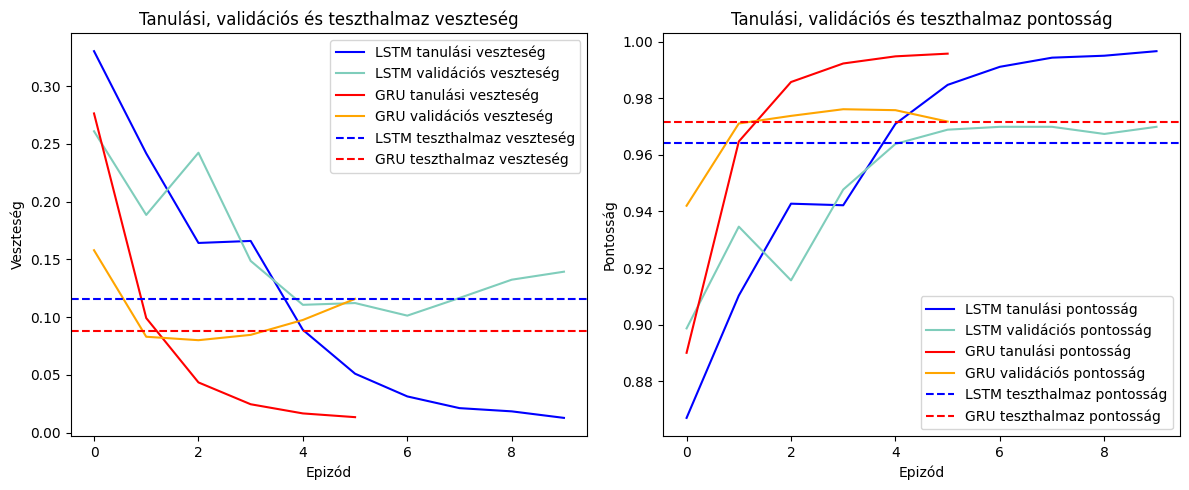

In [19]:
test_loss_lstm, test_accuracy_lstm = lstm_trainable.evaluate(padded_test, y_test, verbose=0)
test_loss_gru, test_accuracy_gru = gru_trainable.evaluate(padded_test, y_test, verbose=0)

# Ábra létrehozása két alábrával
plt.figure(figsize=(12, 5))

# Tanulási, validációs és teszthalmaz veszteség ábrázolása
plt.subplot(1, 2, 1)
plt.plot(lstm_history_trainable.history['loss'], label='LSTM tanulási veszteség', color='blue')
plt.plot(lstm_history_trainable.history['val_loss'], label='LSTM validációs veszteség', color='#7fcdbb')
plt.plot(history_gru_trainable.history['loss'], label='GRU tanulási veszteség', color='red')
plt.plot(history_gru_trainable.history['val_loss'], label='GRU validációs veszteség', color='orange')
plt.axhline(y=test_loss_lstm, color='blue', linestyle='--', label='LSTM teszthalmaz veszteség')  # LSTM teszt loss
plt.axhline(y=test_loss_gru, color='red', linestyle='--', label='GRU teszthalmaz veszteség')  # GRU teszt loss
plt.xlabel('Epizód')
plt.ylabel('Veszteség')
plt.legend()
plt.title('Tanulási, validációs és teszthalmaz veszteség')

# Ttanulási, validációs és teszthalmaz precízió ábrázolása
if 'accuracy' in lstm_history_trainable.history and 'accuracy' in history_gru_trainable.history:
    plt.subplot(1, 2, 2)
    plt.plot(lstm_history_trainable.history['accuracy'], label='LSTM tanulási pontosság', color='blue')
    plt.plot(lstm_history_trainable.history['val_accuracy'], label='LSTM validációs pontosság', color='#7fcdbb')
    plt.plot(history_gru_trainable.history['accuracy'], label='GRU tanulási pontosság', color='red')
    plt.plot(history_gru_trainable.history['val_accuracy'], label='GRU validációs pontosság', color='orange')
    plt.axhline(y=test_accuracy_lstm, color='blue', linestyle='--', label='LSTM teszthalmaz pontosság')  # LSTM teszt accuracy
    plt.axhline(y=test_accuracy_gru, color='red', linestyle='--', label='GRU teszthalmaz pontosság')  # GRU teszt accuracy
    plt.xlabel('Epizód')
    plt.ylabel('Pontosság')
    plt.legend()
    plt.title('Tanulási, validációs és teszthalmaz pontosság')

plt.tight_layout()
plt.show()
